# 1.KNN estimator with a kernel funtion (20 pts)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(2023)

## 1.1Generate data points

In [3]:
x_train = np.concatenate([np.random.normal(-20, 10, 20), np.random.normal(10, 5, 10)])
x_train =x_train.reshape((-1, 1))

x_test = np.linspace(np.min(x_train),np.max(x_train), 100)
x_test = x_test.reshape((-1, 1))


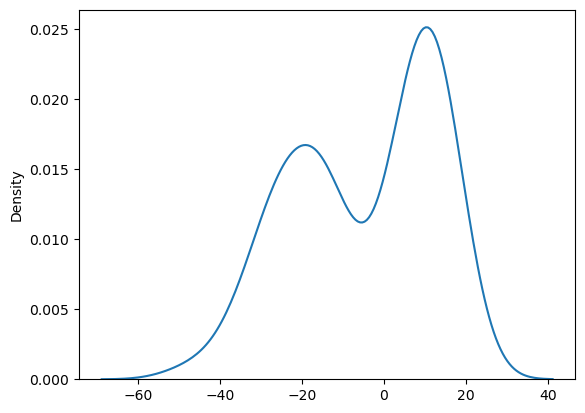

In [4]:
#  sampling  many dpoins for approximating the true distribution
# this is a multimodal density
sns.kdeplot(np.concatenate([np.random.normal(-20, 10, 100), np.random.normal(10, 5, 100)]))
plt.show()

## 1.2 Complete the code and draw the pictures
Completing KNN estimator wtih a kernel funtion. 
The kernel funtion is a Gaussian kernel, defined by $$K(u)=\frac{1}{\sqrt{2\pi}}\exp\left(-\frac{u^2}{\tau}\right),$$
where $\tau$ is the length-scale. 

**Task:** You should complete the code for the KNN estimator with a Gaussian kernel function and plot the estimated density with three sets of parameters, as shown below
- $k=3,\tau=2$
- $k=3,\tau=0.2$
- $k=5,\tau=2$

**Hint:** We have already generated a set of test points and saved them in the variable x_test. Your task is to plot the estimated density function $\hat{p}(x)$ based on these points. The code framework has been provided, and you can either write it from scratch or fill in the missing parts in the framework.

In [5]:
# ##########################
# #Define your KNN estimator 
# #########################

class KNNKernelEstimator:
    def __init__(self, k, tau) -> None:
        self.k = k
        self.tau = tau
        self.p = None
    def gaussian_kernel(self, u):
        return (1 / np.sqrt(2 * np.pi)) * np.exp(-u ** 2 / self.tau)
    def fit(self, x_train):
        self.x = self.gaussian_kernel(x_train)
    def predict(self, x_test):
        p_hat = np.zeros(len(x_test))
        x_test = self.gaussian_kernel(x_test)
    # Loop over each test point
        for i in range(len(x_test)):
            # Compute the distance between the test point and each data point
            dist = np.abs(self.x - x_test[i])
            # Sort the distances and find the k nearest neighbors
            idx = np.argsort(dist)
            nn = self.x[idx[:self.k]]
            
            # Compute the weights for each neighbor using the Gaussian kernel function
            # weights = self.gaussian_kernel(dist[idx[:self.k]])
            weights = dist[idx[:self.k]]
            # Normalize the weights so that they sum up to one
            
            # Compute the estimated density value as the weighted average of the neighbors
            # print(weights)
            p_hat[i] = np.mean(weights) / np.sum(dist)
        
        # Return the estimated density values
        # print(p_hat)
        return p_hat


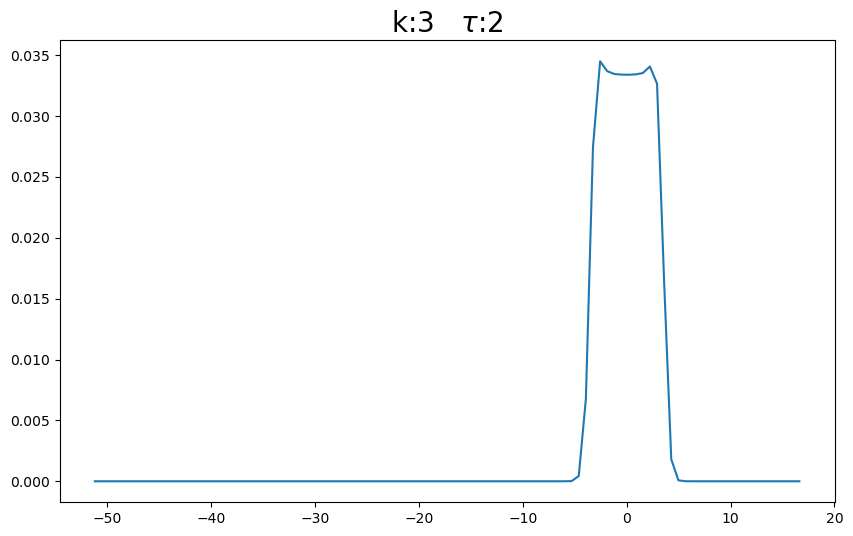

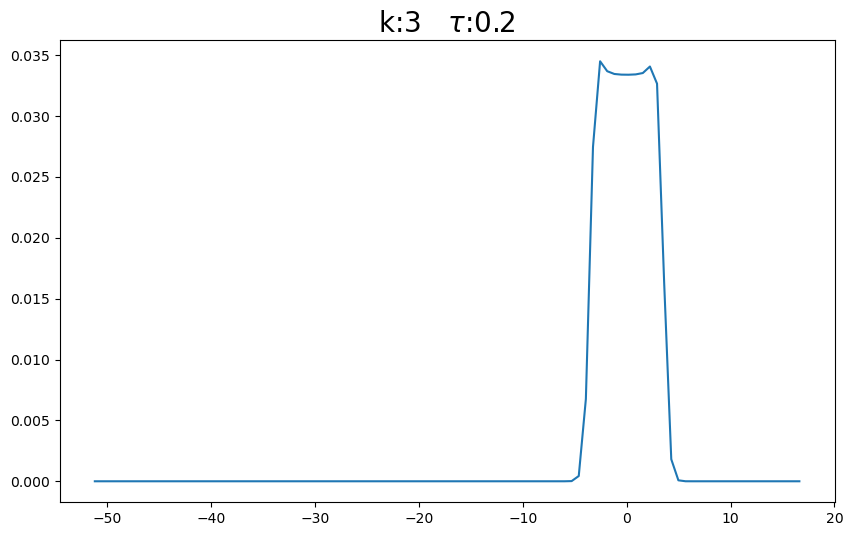

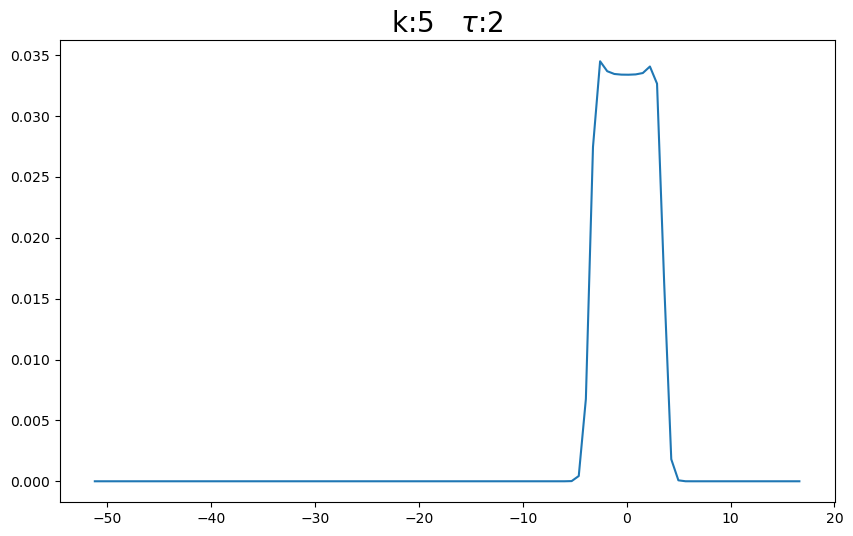

In [6]:
k = 3
tau = 2
##################
#Fill in the blanks by your code or using following template
kke = KNNKernelEstimator(k,tau)
kke.fit(x_train)
predict_x = kke.predict(x_test)
###################

plt.figure(figsize=(10, 6))
plt.plot(x_test, predict_x)
plt.title("k:" + str(k) + r"   $\tau$:" + str(tau), fontsize=20)
plt.show()

k = 3
tau = 0.2
##################
#Fill in the blanks by your code
###################
plt.figure(figsize=(10, 6))
plt.plot(x_test, predict_x)
plt.title("k:" + str(k) + r"   $\tau$:" + str(tau), fontsize=20)
plt.show()

k = 5
tau = 2
##################
#Fill in the blanks by your code
###################
plt.figure(figsize=(10, 6))
plt.plot(x_test, predict_x)
plt.title("k:" + str(k) + r"   $\tau$:"+str(tau), fontsize=20)
plt.show()

# 2.Deep Learning for classification (30 pts)

For this task, you are required to design and train a deep neural network to perform a classification task on a provided dataset. The dataset can be found at the following link: http://pan.shanghaitech.edu.cn/cloudservice/outerLink/decode?c3Vnb24xNjgyNzcwODk4OTU5c3Vnb24=

The dataset consists of a training set and test set. The training set should be used to train your model, and the test set should be used to evaluate the performance of your model.

**Your goal is to achieve at least 70% accuracy on the test set using your trained model. One point is deducted for every point the accuracy decreases**， such as 66.2% will lose 4 points.

If your computer does not have the necessary resources to train a deep neural network, you may use the computing resources of a school computing cluster, Kaggle, or Google Colab.

Hint:The use of pre-training models is prohibited (direct zero points) and custom neural networks are encouraged.



In [7]:
import os
import numpy as np
#!pip install opencv-python  # the command for installing opencv,i.e, cv2
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import time
import warnings
import  torch.nn.functional as F

warnings.filterwarnings("ignore")


In [8]:
# load the data set
def readfile(path, label):
    image_dir = sorted(os.listdir(path))
    x = np.zeros((len(image_dir), 128, 128, 3), dtype=np.uint8)
    y = np.zeros((len(image_dir)), dtype=np.uint8)
    for i, file in enumerate(image_dir):
        img = cv2.imread(os.path.join(path, file))
        x[i, :, :] = cv2.resize(img,(128, 128))
        if label:
          y[i] = int(file.split("_")[0])
    if label:
      return x, y
    else:
      return x

In [9]:
workspace_dir = './food-11'
print("Reading data")
train_x, train_y = readfile(os.path.join(workspace_dir, "training"), True)
print("Size of training data = {}".format(len(train_x)))
test_x, test_y = readfile(os.path.join(workspace_dir, "testing"), True)
print("Size of test data = {}".format(len(test_x)))

Reading data
Size of training data = 9866
Size of test data = 3430


In [10]:
transform_list = [
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]

train_transform = transforms.Compose(transform_list)
test_transform = transforms.Compose(transform_list)

class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y)
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X

In [11]:
batch_size = 64
train_set = ImgDataset(train_x, train_y, train_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = ImgDataset(test_x, test_y, test_transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# 2.2 Construct deep learning model

In [16]:
import torch.nn as nn
import gc

gc.collect()
torch.cuda.empty_cache()

class ConvLayer(nn.Module):
    def __init__(self, F1, F2, F3, f, s):
        super(ConvLayer, self).__init__()
        # create the main path blocks
        self.main1 = nn.Sequential(
            nn.Conv2d(in_channels=F1, out_channels=F2, kernel_size=1, stride=s, padding=0),
            nn.BatchNorm2d(num_features=F2),
            nn.ReLU()
        )
        self.main2 = nn.Sequential(
            nn.Conv2d(in_channels=F2, out_channels=F2, kernel_size=f, stride=1, padding='same'),
            nn.BatchNorm2d(num_features=F2),
            nn.ReLU()
        )
        self.main3 = nn.Sequential(
            nn.Conv2d(in_channels=F2, out_channels=F3, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=F3),
            nn.ReLU()
        )
        # create the skip-connection block
        self.skip = nn.Sequential(
            nn.Conv2d(in_channels=F1, out_channels=F3, kernel_size=1, stride=s, padding=0),
            nn.BatchNorm2d(num_features=F3)
        )
    
    def forward(self, x):
        x_main = self.main1(x)
        x_main = self.main2(x_main)
        x_main = self.main3(x_main)
        x_skip = self.skip(x)
        x_output = x_main + x_skip
        return x_output
    
class IdentityLayer(nn.Module):
    def __init__(self, F1, F2, F3, f):
        super().__init__()
        # create the main path blocks
        self.main1 = nn.Sequential(
            nn.Conv2d(in_channels=F1, out_channels=F2, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=F2),
            nn.ReLU()
        )
        self.main2 = nn.Sequential(
            nn.Conv2d(in_channels=F2, out_channels=F2, kernel_size=f, stride=1, padding='same'),
            nn.BatchNorm2d(num_features=F2),
            nn.ReLU()
        )
        self.main3 = nn.Sequential(
            nn.Conv2d(in_channels=F2, out_channels=F3, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=F3)
        )
        # create the skip-connection block
        self.skip = nn.Identity()
    
    def forward(self, x):
        # apply the main path blocks
        x_main = self.main1(x)
        x_main = self.main2(x_main)
        x_main = self.main3(x_main)
        # apply the skip-connection block
        x_skip = self.skip(x)
        # add the main path and the skip-connection outputs
        x_output = x_main + x_skip
        # apply ReLU activation
        x_output = nn.functional.relu(x_output)
        return x_output

class ResNet50(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # create the zero-padding layer
        self.pad = nn.ZeroPad2d(3)
        # create the stage 1 block
        self.stage1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=0),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        # create the stage 2 block
        self.stage2 = nn.Sequential(
            ConvLayer(F1=64, F2=64, F3=256, f=3, s=1),
            IdentityLayer(F1=256, F2=64, F3=256, f=3),
            IdentityLayer(F1=256, F2=64, F3=256, f=3)
        )
        # create the stage 3 block
        self.stage3 = nn.Sequential(
            ConvLayer(F1=256, F2=128, F3=512, f=3, s=2),
            IdentityLayer(F1=512, F2=128, F3=512, f=3),
            IdentityLayer(F1=512, F2=128, F3=512, f=3),
            IdentityLayer(F1=512, F2=128, F3=512, f=3)
        )
        # create the stage 4 block
        self.stage4 = nn.Sequential(
            ConvLayer(F1=512, F2=256, F3=1024, f=3, s=2),
            IdentityLayer(F1=1024, F2=256, F3=1024, f=3),
            IdentityLayer(F1=1024, F2=256, F3=1024, f=3),
            IdentityLayer(F1=1024, F2=256, F3=1024, f=3),
            IdentityLayer(F1=1024, F2=256, F3=1024, f=3),
            IdentityLayer(F1=1024, F2=256, F3=1024, f=3)
        )
        # create the stage 5 block
        self.stage5 = nn.Sequential(
            ConvLayer(F1=1024, F2=512, F3=2048, f=3,s = 2),
            IdentityLayer(F1 = 2048,F2 = 512,F3 = 2048,f = 3),
            IdentityLayer(F1 = 2048,F2 = 512,F3 = 2048,f = 3)
        )
        # create the average pooling layer
        self.avg_pool = nn.AvgPool2d(kernel_size=(2 , 2))
        # create the flatten layer
        self.flatten = nn.Flatten()
        # create the fully connected layer
        self.fc = nn.Linear(in_features = 8192, out_features=num_classes)
    
    def forward(self,x):
        # apply the zero-padding layer
        x = self.pad(x)
        # apply the stage blocks
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        # apply the average pooling layer
        x = self.avg_pool(x)
        # apply the flatten layer
        x = self.flatten(x)
        # apply the fully connected layer
        x = self.fc(x)
        
        return x


## 2.3 training your model
There are some tips which I hope can help you complete the task:
- If the loss function goes down too slowly, you can make the step size larger. This trick is better combined with an adaptive learning rate regulator
- If the model is overfitting, you can add a dropout layer in your model. 
-  [Data augmentation](https://pytorch.org/vision/stable/transforms.html) is also a good way to increase model generalization. We recommend that you do this.


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50(11)
model.to(device)
loss = nn.CrossEntropyLoss(ignore_index=10)
optimizer = optim.Adam(model.parameters(), lr=0.075)
num_epoch = 100

# Create a ReduceLROnPlateau scheduler object
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=1e-2, patience=10)

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0

    model.train()
    for i, data in enumerate(train_loader):
        X_train, y_train = data
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        optimizer.zero_grad()
        train_pred = model(X_train)
        batch_loss = loss(train_pred, y_train)
        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss
        batch_loss.backward()
        optimizer.step()

    print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f' % (epoch + 1, num_epoch, time.time()-epoch_start_time, train_acc / train_set.__len__(), train_loss / train_set.__len__()))
    model.eval()
    test_acc = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            X_test, y_test = data
            X_test = X_test.to(device)
            test_pred = model(X_test)
            test_acc += np.sum(np.argmax(test_pred.cpu().data.numpy(), axis=1) == data[1].numpy())

    test_acc = test_acc / test_set.__len__()
    print("Test Acc: " + str(test_acc))

[001/100] 19.19 sec(s) Train Acc: 0.146969 Loss: 0.176429
Test Acc: 0.17463556851311954
[002/100] 18.51 sec(s) Train Acc: 0.174742 Loss: 0.034045
Test Acc: 0.17755102040816326
[003/100] 17.97 sec(s) Train Acc: 0.184675 Loss: 0.033703
Test Acc: 0.18513119533527697
[004/100] 18.42 sec(s) Train Acc: 0.184066 Loss: 0.033569
Test Acc: 0.18688046647230322
[005/100] 18.64 sec(s) Train Acc: 0.188628 Loss: 0.033534
Test Acc: 0.18571428571428572
[006/100] 18.89 sec(s) Train Acc: 0.195216 Loss: 0.033396
Test Acc: 0.17959183673469387
[007/100] 18.45 sec(s) Train Acc: 0.196838 Loss: 0.033241
Test Acc: 0.20058309037900873
[008/100] 18.50 sec(s) Train Acc: 0.199473 Loss: 0.033125
Test Acc: 0.20816326530612245
[009/100] 18.36 sec(s) Train Acc: 0.195419 Loss: 0.033058
Test Acc: 0.18775510204081633
[010/100] 18.59 sec(s) Train Acc: 0.208190 Loss: 0.032823
Test Acc: 0.1947521865889213
[011/100] 18.60 sec(s) Train Acc: 0.215893 Loss: 0.032604
Test Acc: 0.23323615160349853
[012/100] 18.23 sec(s) Train Acc:

# Test your model
use your trained model to test the test set and print the accuracy.

In [20]:
model.eval()
test_acc = 0
with torch.no_grad():
    for i, data in enumerate(test_loader):
        X_test, y_test = data
        X_test = X_test.to(device)
        test_pred = model(X_test)
        test_acc += np.sum(np.argmax(test_pred.cpu().data.numpy(), axis=1) == data[1].numpy())

test_acc = test_acc/test_set.__len__()
print("Test Acc: " + str(test_acc))

Test Acc: 0.40408163265306124
